## Import libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.tensorboard import SummaryWriter
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.feature_extraction.text import CountVectorizer
import torch
from torch.utils.data import TensorDataset, DataLoader

## Set device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load and Preprocess Data

In [3]:
train_url = "https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv"
test_url = "https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/test.tsv"
imdb_url = "https://raw.githubusercontent.com/Ankit152/IMDB-sentiment-analysis/master/IMDB-Dataset.csv"

In [4]:
train_data = pd.read_csv(train_url, sep='\t',header=None)
print(f"Training data shape: {train_data.shape}")
print(train_data.head())

test_data = pd.read_csv(test_url, sep='\t',header=None)
print(f"Test data shape: {test_data.shape}")
print(test_data.head())


train_data_final, val_data = train_test_split(train_data, test_size=0.2, random_state=42)
print(f"Final training set size: {len(train_data_final)}")
print(f"Validation set size: {len(val_data)}")

Training data shape: (6920, 2)
                                                   0  1
0  a stirring , funny and finally transporting re...  1
1  apparently reassembled from the cutting room f...  0
2  they presume their audience wo n't sit still f...  0
3  this is a visually stunning rumination on love...  1
4  jonathan parker 's bartleby should have been t...  1
Test data shape: (1821, 2)
                                                   0  1
0       no movement , no yuks , not much of anything  0
1  a gob of drivel so sickly sweet , even the eag...  0
2  gangs of new york is an unapologetic mess , wh...  0
3  we never really feel involved with the story ,...  0
4              this is one of polanski 's best films  1
Final training set size: 5536
Validation set size: 1384


# Bag of Words

## Create the bag-of-words for STT 2 data

In [5]:
vectorizer = CountVectorizer(max_features=10000, stop_words=None)

text_column_index = 0
label_column_index = 1

train_data_final.iloc[:, text_column_index] = train_data_final.iloc[:, text_column_index].astype(str)
val_data.iloc[:, text_column_index] = val_data.iloc[:, text_column_index].astype(str)
test_data.iloc[:, text_column_index] = test_data.iloc[:, text_column_index].astype(str)

X_train = vectorizer.fit_transform(train_data_final.iloc[:, text_column_index].values).toarray()
X_val = vectorizer.transform(val_data.iloc[:, text_column_index].values).toarray()
X_test = vectorizer.transform(test_data.iloc[:, text_column_index].values).toarray()

print("Vocabulary size:", len(vectorizer.vocabulary_))

y_train = train_data_final.iloc[:, label_column_index].values
y_val = val_data.iloc[:, label_column_index].values
y_test = test_data.iloc[:, label_column_index].values

if not np.issubdtype(y_train.dtype, np.integer):
    y_train = y_train.astype(int)
    y_val = y_val.astype(int)
    y_test = y_test.astype(int)

Vocabulary size: 10000


In [6]:
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

## Define the model architecture

In [7]:
class SentimentMLP(nn.Module):
    def __init__(self, input_size=10000):
        super(SentimentMLP, self).__init__()
        self.layer1 = nn.Linear(input_size, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 128)
        self.layer4 = nn.Linear(128, 64)
        self.layer5 = nn.Linear(64, 2)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.dropout(self.relu(self.layer1(x)))
        x = self.dropout(self.relu(self.layer2(x)))
        x = self.dropout(self.relu(self.layer3(x)))
        x = self.dropout(self.relu(self.layer4(x)))
        x = self.layer5(x)
        return x

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = SentimentMLP().to(device)
total_params = count_parameters(model)

## Model Summary

In [8]:
print("Model Summary:")
print("="*50)
print(f"Input Size: 10000")
print(f"Layer 1: Linear(10000, 512)")
print(f"    Parameters: {10000 * 512 + 512}")
print(f"    Activation: ReLU + Dropout(0.3)")
print(f"Layer 2: Linear(512, 256)")
print(f"    Parameters: {512 * 256 + 256}")
print(f"    Activation: ReLU + Dropout(0.3)")
print(f"Layer 3: Linear(256, 128)")
print(f"    Parameters: {256 * 128 + 128}")
print(f"    Activation: ReLU + Dropout(0.3)")
print(f"Layer 4: Linear(128, 64)")
print(f"    Parameters: {128 * 64 + 64}")
print(f"    Activation: ReLU + Dropout(0.3)")
print(f"Layer 5: Linear(64, 2)")
print(f"    Parameters: {64 * 2 + 2}")
print(f"Total Parameters: {total_params}")

Model Summary:
Input Size: 10000
Layer 1: Linear(10000, 512)
    Parameters: 5120512
    Activation: ReLU + Dropout(0.3)
Layer 2: Linear(512, 256)
    Parameters: 131328
    Activation: ReLU + Dropout(0.3)
Layer 3: Linear(256, 128)
    Parameters: 32896
    Activation: ReLU + Dropout(0.3)
Layer 4: Linear(128, 64)
    Parameters: 8256
    Activation: ReLU + Dropout(0.3)
Layer 5: Linear(64, 2)
    Parameters: 130
Total Parameters: 5293122


## Training and Checkpointing model

### Helper function for train

In [9]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

### Helper function for testing

In [10]:
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = running_loss / total
    val_acc = 100. * correct / total

    return val_loss, val_acc

### Helper function to get confusion matrix

In [11]:
def plot_cm(model, X, y, device):
    model.eval()
    with torch.no_grad():
        outputs = model(X)
        cm = confusion_matrix(y, outputs.argmax(dim=1).cpu().numpy())
        return cm

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
best_val_acc = 0.0
checkpoint_path = 'checkpoint.pt'
writer = SummaryWriter("runs/bow")

In [13]:
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)
    writer.add_scalar('Accuracy/train', train_acc, epoch)
    writer.add_scalar('Accuracy/val', val_acc, epoch)
    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    # Save the best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }, checkpoint_path)
        print(f'Checkpoint saved at epoch {epoch+1} with validation accuracy: {val_acc:.2f}%')

print(f"Training completed. Best validation accuracy: {best_val_acc:.2f}%")

Epoch 1/10, Train Loss: 0.6049, Train Acc: 66.49%, Val Loss: 0.4579, Val Acc: 79.41%
Checkpoint saved at epoch 1 with validation accuracy: 79.41%
Epoch 2/10, Train Loss: 0.2769, Train Acc: 89.14%, Val Loss: 0.4567, Val Acc: 80.85%
Checkpoint saved at epoch 2 with validation accuracy: 80.85%
Epoch 3/10, Train Loss: 0.0826, Train Acc: 96.80%, Val Loss: 0.7230, Val Acc: 79.99%
Epoch 4/10, Train Loss: 0.0204, Train Acc: 99.22%, Val Loss: 1.1589, Val Acc: 78.83%
Epoch 5/10, Train Loss: 0.0042, Train Acc: 99.80%, Val Loss: 1.7327, Val Acc: 78.90%
Epoch 6/10, Train Loss: 0.0024, Train Acc: 99.98%, Val Loss: 2.2844, Val Acc: 77.75%
Epoch 7/10, Train Loss: 0.0092, Train Acc: 99.71%, Val Loss: 1.5106, Val Acc: 77.75%
Epoch 8/10, Train Loss: 0.0103, Train Acc: 99.64%, Val Loss: 1.6970, Val Acc: 76.45%
Epoch 9/10, Train Loss: 0.0076, Train Acc: 99.71%, Val Loss: 1.6303, Val Acc: 77.75%
Epoch 10/10, Train Loss: 0.0031, Train Acc: 99.89%, Val Loss: 1.7012, Val Acc: 78.40%
Training completed. Best va

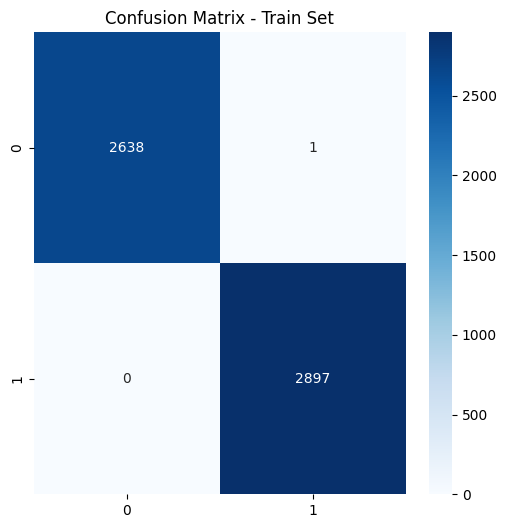

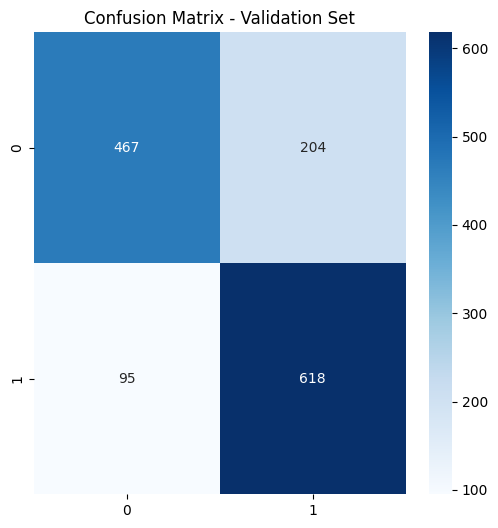

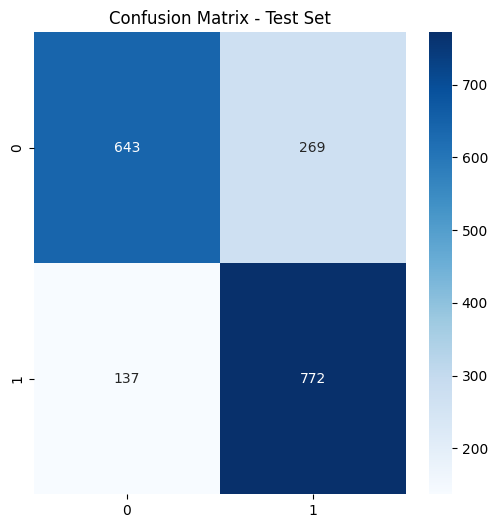

Loaded best model from epoch 2 with validation accuracy: 80.85%


In [14]:
train_cm = plot_cm(model, X_train_tensor.to(device), y_train_tensor, device)
val_cm = plot_cm(model, X_val_tensor.to(device), y_val_tensor, device)
test_cm = plot_cm(model, X_test_tensor.to(device), y_test_tensor, device)

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_title('Confusion Matrix - Train Set')
plt.show()
writer.add_figure('Confusion Matrix/train', fig)

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_title('Confusion Matrix - Validation Set')
plt.show()
writer.add_figure('Confusion Matrix/val', fig)

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_title('Confusion Matrix - Test Set')
plt.show()
writer.add_figure('Confusion Matrix/test', fig)

test_loss, test_acc = validate(model, test_loader, criterion, device)
writer.add_scalar('Loss/test', test_loss, epoch)
writer.add_scalar('Accuracy/test', test_acc, epoch)
writer.close()

checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']} with validation accuracy: {checkpoint['val_acc']:.2f}%")

# Continual Learning on IMDB dataset

## Load and Preprocess data

In [15]:
imdb_url = "https://raw.githubusercontent.com/Ankit152/IMDB-sentiment-analysis/master/IMDB-Dataset.csv"
imdb_data = pd.read_csv(imdb_url)
print(f"IMDB dataset shape: {imdb_data.shape}")
print(imdb_data.head())

imdb_data['sentiment_label'] = imdb_data['sentiment'].map({'negative': 0, 'positive': 1})

imdb_train, imdb_val = train_test_split(imdb_data, test_size=0.2, random_state=42)
print(f"IMDB train set size: {len(imdb_train)}")
print(f"IMDB validation set size: {len(imdb_val)}")

IMDB dataset shape: (50000, 2)
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
IMDB train set size: 40000
IMDB validation set size: 10000


In [16]:
vectorizer_imdb = CountVectorizer(max_features=10000)
X_imdb_train = vectorizer_imdb.fit_transform(imdb_train['review']).toarray()
X_imdb_val = vectorizer_imdb.transform(imdb_val['review']).toarray()

y_imdb_train = imdb_train['sentiment_label'].values
y_imdb_val = imdb_val['sentiment_label'].values

X_imdb_train_tensor = torch.FloatTensor(X_imdb_train)
y_imdb_train_tensor = torch.LongTensor(y_imdb_train)
X_imdb_val_tensor = torch.FloatTensor(X_imdb_val)
y_imdb_val_tensor = torch.LongTensor(y_imdb_val)

imdb_train_dataset = TensorDataset(X_imdb_train_tensor, y_imdb_train_tensor)
imdb_val_dataset = TensorDataset(X_imdb_val_tensor, y_imdb_val_tensor)

imdb_train_loader = DataLoader(imdb_train_dataset, batch_size=batch_size, shuffle=True)
imdb_val_loader = DataLoader(imdb_val_dataset, batch_size=batch_size)

###  Load and train Checkpointed Model

In [17]:
model.load_state_dict(checkpoint['model_state_dict'])

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 5
best_val_acc = 0.0
imdb_checkpoint_path = 'imdb_checkpoint.pt'

writer = SummaryWriter("runs/bow_imdb")

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, imdb_train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, imdb_val_loader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }, imdb_checkpoint_path)
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Loss/val', val_loss, epoch)
        writer.add_scalar('Accuracy/train', train_acc, epoch)
        writer.add_scalar('Accuracy/val', val_acc, epoch)
        print(f'Checkpoint saved at epoch {epoch+1} with validation accuracy: {val_acc:.2f}%')

print(f"Fine-tuning completed. Best validation accuracy: {best_val_acc:.2f}%")

checkpoint = torch.load(imdb_checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best fine-tuned model from epoch {checkpoint['epoch']} with validation accuracy: {checkpoint['val_acc']:.2f}%")

Epoch 1/5, Train Loss: 0.9617, Train Acc: 71.38%, Val Loss: 0.3061, Val Acc: 88.15%
Checkpoint saved at epoch 1 with validation accuracy: 88.15%
Epoch 2/5, Train Loss: 0.2834, Train Acc: 89.22%, Val Loss: 0.2555, Val Acc: 89.87%
Checkpoint saved at epoch 2 with validation accuracy: 89.87%
Epoch 3/5, Train Loss: 0.2112, Train Acc: 92.12%, Val Loss: 0.2570, Val Acc: 89.79%
Epoch 4/5, Train Loss: 0.1570, Train Acc: 94.42%, Val Loss: 0.2781, Val Acc: 89.39%
Epoch 5/5, Train Loss: 0.0958, Train Acc: 96.76%, Val Loss: 0.3468, Val Acc: 88.96%
Fine-tuning completed. Best validation accuracy: 89.87%
Loaded best fine-tuned model from epoch 2 with validation accuracy: 89.87%


In [18]:
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            _, predictions = torch.max(outputs, 1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    total_samples = len(all_labels)
    val_loss = running_loss / total_samples
    val_accuracy = accuracy_score(all_labels, all_predictions) * 100

    report = classification_report(all_labels, all_predictions, target_names=['negative', 'positive'])

    conf_matrix = confusion_matrix(all_labels, all_predictions)

    return val_loss, val_accuracy, report, conf_matrix

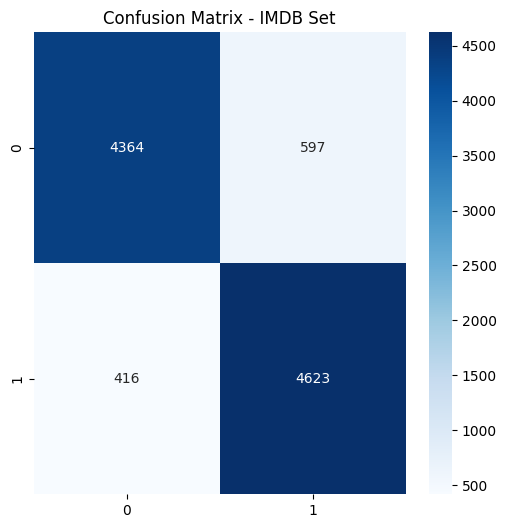

In [19]:
imdb_outputs = evaluate_model(model, imdb_val_loader, criterion, device)
writer.add_scalar('Loss/imdb', imdb_outputs[0], epoch)
writer.add_scalar('Accuracy/imdb', imdb_outputs[1], epoch)
writer.add_text('Classification Report/imdb', imdb_outputs[2], epoch)
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(imdb_outputs[3], annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_title('Confusion Matrix - IMDB Set')
plt.show()
writer.add_figure('Confusion Matrix/imdb', fig)
writer.close()